## Libraries

In [1]:
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

import matplotlib.pyplot as plt
# import graphviz
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
import pickle
import graphviz

In [2]:
# import plotly.express as px
import cufflinks as cf
cf.go_offline()

In [3]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
%run ..\..\Data\triangulars.ipynb

## Functions

In [5]:
# custom metric
def _mape(y, y_pred, w):
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),np.maximum(0.001, y)))
    
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

In [6]:
def _cos_7(x1):
    return np.cos(2*np.pi*(x1/7))
    
cos_7 = make_function(function=_cos_7,
                        name='cos_7',
                        arity=1)

def _sin_7(x1):
    return np.sin(2*np.pi*(x1/7))
    
sin_7 = make_function(function=_sin_7,
                        name='sin_7',
                        arity=1)

In [7]:
def _cos_365(x1):
    return np.cos(2*np.pi*(x1/365))
    
cos_365 = make_function(function=_cos_365,
                        name='cos_365',
                        arity=1)

def _sin_365(x1):
    return np.sin(2*np.pi*(x1/365))
    
sin_365 = make_function(function=_sin_365,
                        name='sin_365',
                        arity=1)

In [8]:
def _cos_372(x1):
    return np.cos(2*np.pi*(x1/372))
    
cos_372 = make_function(function=_cos_372,
                        name='cos_372',
                        arity=1)

def _sin_372(x1):
    return np.sin(2*np.pi*(x1/372))
    
sin_372 = make_function(function=_sin_372,
                        name='sin_372',
                        arity=1)

In [9]:
def abscos_14(x1):
    return np.abs(np.cos(2*np.pi*(x1/14)))
    
abscos_14 = make_function(function=abscos_14,
                        name='abscos_14',
                        arity=1)

def abssin_14(x1):
    return np.abs(np.sin(2*np.pi*(x1/14)))
    
abssin_14 = make_function(function=abssin_14,
                        name='abssin_14',
                        arity=1)

In [10]:
def one(x1):
    return np.ones(len(x1))

one = make_function(function = one, 
                    name = 'one', 
                    arity = 1)

In [11]:
def time(x1):
    return np.arange(1, len(x1)+1)

time = make_function(function = time,
                    name = 'time',
                    arity = 1)

## Load data

In [12]:
path_consumo = Path().resolve().parents[1] / "Data" / "Data1.xlsx"
consumo = pd.read_excel(path_consumo)
consumo = consumo.set_index("fecha").loc["2007-01-01":"2020-03-30"]

In [13]:
festivos=pd.read_excel(Path().resolve().parents[1] / "Data" /"Festivos.xlsx")
festivos2=pd.read_excel(Path().resolve().parents[1] / "Data" / "Festivos2.xlsx")

In [17]:
t = np.arange(1, consumo.size+1).reshape(-1, 1)
day = consumo.index.dayofyear
weekd = consumo.index.weekday
month = consumo.index.month
month1 = pd.get_dummies(month, prefix = "month", drop_first = True).to_numpy()

fest = triangulars().festivos(X = consumo, festivos = festivos, festivos2 = festivos2).to_numpy()
weekd1 = pd.get_dummies(weekd, prefix = "wday", drop_first = True).to_numpy()
# weekd1.index = consumo.index

X = triangulars().diffseason(consumo)
# X1 = pd.concat([X, fest, weekd1], axis = 1)
# X1["t"] = t/t.max()
# X1["day"] = day/day.max()

In [ ]:
col = pd.DataFrame()
wend=consumo.index.weekday
wday=consumo.index.weekday
col["wend"]=wend
col["wday"]=wday
col["wend"] = col["wend"].replace([0,1,2,3,4,5,6],[0,0,0,0,0,1,1])
col["wday"] = col["wday"].replace([0,1,2,3,4,5,6],[1,1,1,1,1,0,0])
col = col.to_numpy()

In [ ]:
X_train, X_test, y_train1, y_test1 = train_test_split(np.c_[t, day, month1, fest, weekd1, col], consumo, test_size = 365, shuffle = False)

# scaler = MaxAbsScaler(); scaler.fit(X_train); X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

scaler1 = MaxAbsScaler(); scaler1.fit(y_train1)
y_train = scaler1.transform(y_train1).reshape(-1)
y_test = scaler1.transform(y_test1).reshape(-1)

## LinReg

In [ ]:
run = LinearRegression(n_jobs = -1)

In [ ]:
run.fit(X_train, y_train)

In [ ]:
y_res = run.predict(X_train)
y_res_pred = run.predict(X_test)

In [ ]:
y_residual = y_train - y_res
y_residual_pred = y_test - y_res_pred

In [ ]:
pd.DataFrame(np.c_[y_train, y_res], index = y_train1.index, columns = ["real", "pred"]).iplot()

In [15]:
pd.DataFrame(y_residual_pred, index = y_test1.index).iplot()

NameError: name 'y_residual_pred' is not defined

## fit

In [49]:
X_train, X_test = train_test_split(t, test_size = 365, shuffle = False)

In [50]:
model = SymbolicRegressor(population_size=2000, init_method = "half and half",
                           p_crossover=0.6, p_subtree_mutation = 0.3, p_hoist_mutation = 0.05, warm_start = True,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs', cos_7,
                                         sin_7, cos_365, sin_365, abscos_14, abssin_14), 
#                            metric = 'rmse',
                           max_samples = 0.95,
                           generations=200, stopping_criteria=0.01, parsimony_coefficient=0.000005,
                           verbose=1, random_state=0)


In [51]:
model.fit(X_train, y_residual)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.90      8.41985e+06        3        0.0335423        0.0354087     18.50m
   1     9.01          16765.5       12        0.0327213        0.0328052     19.60m
   2    12.12           480253       14        0.0316783        0.0329873     20.73m
   3    12.02          6766.74       33        0.0295912        0.0313619     22.34m
   4    15.19          3333.99       29        0.0291574        0.0296854     21.83m
   5    17.80          3518.45       41        0.0279174        0.0276625     21.89m
   6    23.69          8119.17       55         0.026253        0.0278486     25.08m
   7    34.83          3353.22       50        0.0262399         0.028096     28.82m
   8    48.29          3340.77      107        0.0260041         0.027786  

  94    99.42          3.86996      120        0.0200327        0.0237686     31.72m
  95   100.03          4.06009      105        0.0200932        0.0226277     30.07m
  96   100.92          4.69857      105        0.0200468        0.0234923     30.31m
  97   102.06          2.61503      108        0.0200427        0.0235634     29.99m
  98   102.06         0.892675      104        0.0199743        0.0234538     31.11m
  99   102.53          3.72261      100        0.0200622        0.0234574     30.65m
 100   101.67          4.19551      104        0.0200159        0.0241435     28.73m
 101   101.85          3.72173      104        0.0200586        0.0232783     28.79m
 102   104.29          4.56738      103         0.020022         0.022648     29.21m
 103   101.32           4.3652      109        0.0199309        0.0242874     27.92m
 104   102.47          5.54794      117        0.0199908        0.0231788     28.20m
 105   102.25          2.45633      116        0.0200478        0

 191   107.73          1.36167      130        0.0195345        0.0237861      4.53m
 192   107.41          4.97577      109        0.0195357        0.0237498      3.87m
 193   106.88          4.47026      108        0.0196019        0.0224953      3.17m
 194   105.19          35.3022      109        0.0195788        0.0230108      2.19m
 195   105.78          7.74421      106         0.019633        0.0219853      1.85m
 196   105.13          3330.25      109        0.0196035          0.02249      1.35m
 197   104.30          1.35844      107        0.0195679        0.0231417     53.67s
 198   104.45          4.36954      109         0.019537         0.023802     32.18s
 199   105.02          9.47638      109        0.0195941        0.0227111      0.00s


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs',
                                <gplearn.f...
                  generations=200, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.95, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.6, p_hoist_mutation=0.05, p_point_mutation=0.01,
                  p_point_replace=0.05, p_subtree_mutation=0.3,
                  parsimony_coefficient=5e-06, population_size=2000,
                  random_state=0, stopping_criteria=0.01, tournament_size=20,
                  verbose=1, warm_start=True)

In [52]:
X_train.shape

(4473, 1)

In [53]:
X1.columns

Index(['Invierno1', 'Primavera', 'verano', 'Otoño', 'Otoño2', 'Invierno2',
       'Dom santo', 'NewYear', 'Constitucion', 'Jue santo', 'Vie santo',
       'Madre', 'Grito', 'virgen', 'muertos', 'Virgen2', 'Navidad',
       'nochebuena', 'toma', 'sab santo', 'rev', 'Super bowl', 'Mundial',
       'año viejo', 'Benito', 'Trabajo', 'elecciones', 'Oscar', 'wday_1',
       'wday_2', 'wday_3', 'wday_4', 'wday_5', 'wday_6', 't', 'day'],
      dtype='object')

In [54]:
print(model._program)

sin_365(mul(sub(add(sub(abssin_14(X0), mul(sin(cos(sin_7(abs(X0)))), abs(sub(add(add(abssin_14(X0), sub(abssin_14(X0), cos(abssin_14(X0)))), add(abssin_14(X0), sub(abssin_14(X0), mul(abssin_14(-0.009), sub(add(sin_365(abscos_14(cos(abssin_14(X0)))), -0.494), mul(-0.124, abs(abs(mul(-0.887, X0))))))))), abs(sub(abssin_14(add(X0, X0)), add(add(cos_7(X0), cos_7(X0)), sin_365(sub(sin(0.158), mul(-0.124, X0)))))))))), add(abssin_14(X0), sub(abssin_14(X0), cos(abssin_14(mul(abssin_14(-0.009), sub(sub(abscos_14(0.262), div(cos_365(abssin_14(X0)), sin_365(0.247))), add(X0, X0)))))))), sin_365(sub(div(abssin_14(-0.703), div(cos(cos_365(0.414)), X0)), mul(-0.124, X0)))), abs(sub(-0.197, 0.881))))


## Predict

### Plot residual

#### Test

In [55]:
pred = model.predict(X_test)

In [56]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [57]:
plotting = pd.DataFrame(pred1, index = y_test1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_residual_pred.reshape(-1, 1))
# plotting["real"] = y_residual_pred

In [58]:
plotting[["real", "prediction"]].iplot()

In [59]:
(plotting.real - plotting.prediction ).iplot(title = "residual")

#### Train

In [60]:
pred = model.predict(X_train)

In [61]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [62]:
plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_residual.reshape(-1, 1))

In [65]:
plotting[["real", "prediction"]].iplot()

In [66]:
(plotting.real - plotting.prediction).iplot(title = "residual")

In [67]:
np.mean(np.abs((y_train - pred)/y_train))*100

100.32339177749449

### Plot residuals + predict

#### Test

In [68]:
pred = model.predict(X_test) + y_res_pred

In [69]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [70]:
plotting = pd.DataFrame(pred1, index = y_test1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_test.reshape(-1, 1))

In [71]:
plotting[["real", "prediction"]].iplot()

In [72]:
plotting[["real", "prediction"]].iplot()

In [73]:
(plotting.real - plotting.prediction ).iplot(title = "residual")

In [74]:
np.mean(np.abs((plotting.real - plotting.prediction)/plotting.real))*100

3.491388418733633

#### Train

In [75]:
pred = model.predict(X_train) + y_res

In [76]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [77]:
plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_train.reshape(-1, 1))

In [79]:
plotting[["real", "prediction"]].iplot()

In [80]:
(plotting.real - plotting.prediction).iplot(title = "residual")

In [81]:
np.mean(np.abs((y_train - pred)/y_train))*100

2.760663680403402

In [82]:
print(model._program)

sin_365(mul(sub(add(sub(abssin_14(X0), mul(sin(cos(sin_7(abs(X0)))), abs(sub(add(add(abssin_14(X0), sub(abssin_14(X0), cos(abssin_14(X0)))), add(abssin_14(X0), sub(abssin_14(X0), mul(abssin_14(-0.009), sub(add(sin_365(abscos_14(cos(abssin_14(X0)))), -0.494), mul(-0.124, abs(abs(mul(-0.887, X0))))))))), abs(sub(abssin_14(add(X0, X0)), add(add(cos_7(X0), cos_7(X0)), sin_365(sub(sin(0.158), mul(-0.124, X0)))))))))), add(abssin_14(X0), sub(abssin_14(X0), cos(abssin_14(mul(abssin_14(-0.009), sub(sub(abscos_14(0.262), div(cos_365(abssin_14(X0)), sin_365(0.247))), add(X0, X0)))))))), sin_365(sub(div(abssin_14(-0.703), div(cos(cos_365(0.414)), X0)), mul(-0.124, X0)))), abs(sub(-0.197, 0.881))))


### plot real value

#### Test

In [720]:
pred = model.predict(X_test)

In [721]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [722]:
plotting = pd.DataFrame(pred1, index = y_test1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_test.reshape(-1, 1))

In [592]:
plotting[["real", "prediction"]].iplot()

In [518]:
(plotting.real - plotting.prediction ).iplot(title = "residual")

In [519]:
np.mean(np.abs((plotting.real - plotting.prediction)/plotting.real))*100

12.753428106977976

#### Train

In [520]:
pred = model.predict(X_train)

In [521]:
pred1 = scaler1.inverse_transform(pred.reshape(-1, 1))

In [522]:
plotting = pd.DataFrame(pred1, index = y_train1.index, columns = ["prediction"])
plotting["real"] = scaler1.inverse_transform(y_train.reshape(-1, 1))

In [523]:
plotting[["real", "prediction"]].iplot()

In [524]:
(plotting.real - plotting.prediction).iplot(title = "residual")

In [525]:
np.mean(np.abs((y_train - pred)/y_train))*100

8.278021435021898

In [526]:
print(model._program)

cos(cos(sin_7(div(sub(add(mul(X5, X7), div(X6, X7)), X6), add(X7, X6)))))


## Visualize

In [ ]:
dot_data = model._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

## Save the model

In [781]:
path_to_model = Path().resolve().parents[1] / "Models" / "GRegressor" / "GR_Xtime_dayear_seasondiff-p1000-100it-mae.pkl"
with open(path_to_model, "wb") as f:
    pickle.dump(model, f)

## Seasonal decompose

In [352]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [265]:
tatu = pd.DataFrame(y_residual, index = y_train1.index)

In [273]:
tatu.iplot()

In [269]:
stl = seasonal_decompose(tatu)

In [270]:
flot = stl.seasonal

In [271]:
flot.iplot()

In [272]:
?signal.periodogram

Object `signal.periodogram` not found.


C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in true_divide



(0.0, 400.0)

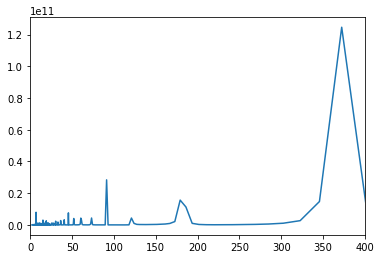

In [409]:
f, asd = signal.periodogram(flot)
# plt.figure()
plt.plot(1/f, asd)
plt.xlim(0, 400)

In [410]:
picos = pd.DataFrame(asd, 1/(f), columns=["potencia"])
picos = picos.sort_values(by="potencia",ascending=False).reset_index().head(12)
picos.columns = ["periodo", "potencia"]

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



In [411]:
picos

periodo      potencia
0   372.153846  1.246128e+11
1    91.283019  2.840338e+10
2   179.185185  1.562952e+10
3   345.571429  1.474192e+10
4   186.076923  1.128929e+10
5     7.021771  7.963636e+09
6    45.641509  7.589072e+09
7   403.166667  5.022084e+09
8    73.303030  4.346734e+09
9   120.950000  4.330696e+09
10   60.475000  4.291014e+09
11   52.021505  4.050108e+09

In [412]:
picos["periodo"].iplot()